In [33]:
import pandas as pd
import fasttext
import numpy as np
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm
import matplotlib.pyplot as plt
import csv
import ast
import re

In [2]:
# get the df with the posts, tokenized posts, birth years, and binary birth years
df_birth_year = pd.read_csv('data/birth_year.csv')
mil_and_genz = df_birth_year[(1986 < df_birth_year['birth_year']) & (df_birth_year['birth_year'] <= 2006)]
mil_and_genz['binary_birth_year'] = 1
mil_and_genz.loc[(1996 < mil_and_genz['birth_year']) & (mil_and_genz['birth_year'] <= 2006), 'binary_birth_year'] = 0
mil_and_genz = mil_and_genz.reset_index(drop=True)
mil_and_genz

# underample the minority class
undersampled_df = pd.concat([
    resample(mil_and_genz[mil_and_genz['binary_birth_year'] == 1],
             replace=False,
             n_samples=len(mil_and_genz[mil_and_genz['binary_birth_year'] == 0]),
             random_state=42),
    mil_and_genz[mil_and_genz['binary_birth_year'] == 0]
])

# shuffle the dataframe
undersampled_df = undersampled_df.sample(frac=1, random_state=42).reset_index(drop=True)

undersampled_df

# tokenization
mil_and_genz['post_tokenized'] = mil_and_genz.post.str.findall('\w+|[^\w\s]')
mil_and_genz

<ipython-input-2-e67fa423ed4e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mil_and_genz['binary_birth_year'] = 1
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,auhtor_ID,post,birth_year,binary_birth_year,post_tokenized
0,t2_rnjzutp,Good on you for being responsible! I know self...,2001,0,"[Good, on, you, for, being, responsible, !, I,..."
1,t2_rnjzutp,"must go to the grocery store with their child,...",2001,0,"[must, go, to, the, grocery, store, with, thei..."
2,t2_rnjzutp,"things on her videos, and YouTube took the vid...",2001,0,"[things, on, her, videos, ,, and, YouTube, too..."
3,t2_rnjzutp,their app. There's also a program called SYNC ...,2001,0,"[their, app, ., There, ', s, also, a, program,..."
4,t2_rnjzutp,"side. If the cops don't take your side, you'll...",2001,0,"[side, ., If, the, cops, don, ', t, take, your..."
...,...,...,...,...,...
25450,t2_ef4dv976,clever political meme on a sub about political...,1989,1,"[clever, political, meme, on, a, sub, about, p..."
25451,t2_7ps3a,Kevin. Glück gehabt. I will try! Thank you! I ...,1992,1,"[Kevin, ., Glück, gehabt, ., I, will, try, !, ..."
25452,t2_7ps3a,Handy/der Cloud speichern und in der Kamera ha...,1992,1,"[Handy, /, der, Cloud, speichern, und, in, der..."
25453,t2_7ps3a,that. :)) On Google I cant find much informati...,1992,1,"[that, ., :, ), ), On, Google, I, cant, find, ..."


In [3]:
# concatenate all posts into a single string and save
corpus = " ".join([" ".join(post) for post in mil_and_genz['post_tokenized']])
with open("data/temp_corpus.txt", "w", encoding="utf-8") as file:
    file.write(corpus)

# fastText word embeddings
model = fasttext.train_unsupervised("data/temp_corpus.txt")
model.save_model("result/trained_fasttext_embeddings.bin")

In [4]:
# load the trained model
model = fasttext.load_model("result/trained_fasttext_embeddings.bin")

# get the average embedding for a post (document embedding)
def get_average_embedding(tokens, model):
    embeddings = [model.get_word_vector(word) for word in tokens if word in model.words]
    if embeddings:
        avg_embedding = np.mean(embeddings, axis=0)
    else:
        avg_embedding = np.zeros(model.get_dimension())  # Default to zero if no embeddings found
    return avg_embedding

mil_and_genz['doc_embedding'] = mil_and_genz['post_tokenized'].apply(lambda x: get_average_embedding(x, model))

# averaging the document embeddings

In [36]:
def calculate_average(lst):
    return sum(lst) / len(lst) if len(lst) > 0 else None

# Apply the function to the specified column and create a new column with averages
mil_and_genz['doc_embedding_average'] = mil_and_genz['doc_embedding'].apply(calculate_average)
mil_and_genz.to_csv('data/mil_and_genz.csv', index=False)

In [37]:
mil_and_genz

,auhtor_ID,post,birth_year,binary_birth_year,post_tokenized,doc_embedding,doc_embedding_average,doc_length
0,t2_rnjzutp,Good on you for being responsible! I know self...,2001,0,"[Good, on, you, for, being, responsible, !, I,...","[0.077345595, -0.14746565, 0.26790008, 0.31544...",0.017216,1550
1,t2_rnjzutp,"must go to the grocery store with their child,...",2001,0,"[must, go, to, the, grocery, store, with, thei...","[0.057216443, -0.12836617, 0.25229907, 0.32476...",0.016122,1560
2,t2_rnjzutp,"things on her videos, and YouTube took the vid...",2001,0,"[things, on, her, videos, ,, and, YouTube, too...","[0.06751289, -0.11984211, 0.2425011, 0.3101618...",0.016001,1542
3,t2_rnjzutp,their app. There's also a program called SYNC ...,2001,0,"[their, app, ., There, ', s, also, a, program,...","[0.059638795, -0.114736974, 0.23432401, 0.3349...",0.016488,1567
4,t2_rnjzutp,"side. If the cops don't take your side, you'll...",2001,0,"[side, ., If, the, cops, don, ', t, take, your...","[0.06526452, -0.09764939, 0.2473862, 0.3262983...",0.016004,1552
...,...,...,...,...,...,...,...,...
25450,t2_ef4dv976,clever political meme on a sub about political...,1989,1,"[clever, political, meme, on, a, sub, about, p...","[0.073144875, -0.124933265, 0.2885858, 0.30519...",0.017437,1074
25451,t2_7ps3a,Kevin. Glück gehabt. I will try! Thank you! I ...,1992,1,"[Kevin, ., Glück, gehabt, ., I, will, try, !, ...","[0.09270658, 0.069318876, 0.06377351, 0.368193...",0.021317,1484
25452,t2_7ps3a,Handy/der Cloud speichern und in der Kamera ha...,1992,1,"[Handy, /, der, Cloud, speichern, und, in, der...","[0.08413791, 0.08132758, 0.046772774, 0.379053...",0.022058,1490
25453,t2_7ps3a,that. :)) On Google I cant find much informati...,1992,1,"[that, ., :, ), ), On, Google, I, cant, find, ...","[0.11956645, 0.18445647, -0.063145295, 0.37309...",0.027131,1504


# adding doc length, should be removed later

In [11]:
# document length
def count_words(tokens):
    return sum(1 for token in tokens if token.isalpha())
mil_and_genz['doc_length'] = mil_and_genz['post_tokenized'].apply(count_words)
mil_and_genz

,auhtor_ID,post,birth_year,binary_birth_year,post_tokenized,doc_embedding,doc_embedding_average,doc_length
0,t2_rnjzutp,Good on you for being responsible! I know self...,2001,0,"[Good, on, you, for, being, responsible, !, I,...","[0.077345595, -0.14746565, 0.26790008, 0.31544...",0.017216,1550
1,t2_rnjzutp,"must go to the grocery store with their child,...",2001,0,"[must, go, to, the, grocery, store, with, thei...","[0.057216443, -0.12836617, 0.25229907, 0.32476...",0.016122,1560
2,t2_rnjzutp,"things on her videos, and YouTube took the vid...",2001,0,"[things, on, her, videos, ,, and, YouTube, too...","[0.06751289, -0.11984211, 0.2425011, 0.3101618...",0.016001,1542
3,t2_rnjzutp,their app. There's also a program called SYNC ...,2001,0,"[their, app, ., There, ', s, also, a, program,...","[0.059638795, -0.114736974, 0.23432401, 0.3349...",0.016488,1567
4,t2_rnjzutp,"side. If the cops don't take your side, you'll...",2001,0,"[side, ., If, the, cops, don, ', t, take, your...","[0.06526452, -0.09764939, 0.2473862, 0.3262983...",0.016004,1552
...,...,...,...,...,...,...,...,...
25450,t2_ef4dv976,clever political meme on a sub about political...,1989,1,"[clever, political, meme, on, a, sub, about, p...","[0.073144875, -0.124933265, 0.2885858, 0.30519...",0.017437,1074
25451,t2_7ps3a,Kevin. Glück gehabt. I will try! Thank you! I ...,1992,1,"[Kevin, ., Glück, gehabt, ., I, will, try, !, ...","[0.09270658, 0.069318876, 0.06377351, 0.368193...",0.021317,1484
25452,t2_7ps3a,Handy/der Cloud speichern und in der Kamera ha...,1992,1,"[Handy, /, der, Cloud, speichern, und, in, der...","[0.08413791, 0.08132758, 0.046772774, 0.379053...",0.022058,1490
25453,t2_7ps3a,that. :)) On Google I cant find much informati...,1992,1,"[that, ., :, ), ), On, Google, I, cant, find, ...","[0.11956645, 0.18445647, -0.063145295, 0.37309...",0.027131,1504


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.62

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      1946
           1       0.62      1.00      0.76      3145

    accuracy                           0.62      5091
   macro avg       0.31      0.50      0.38      5091
weighted avg       0.38      0.62      0.47      5091



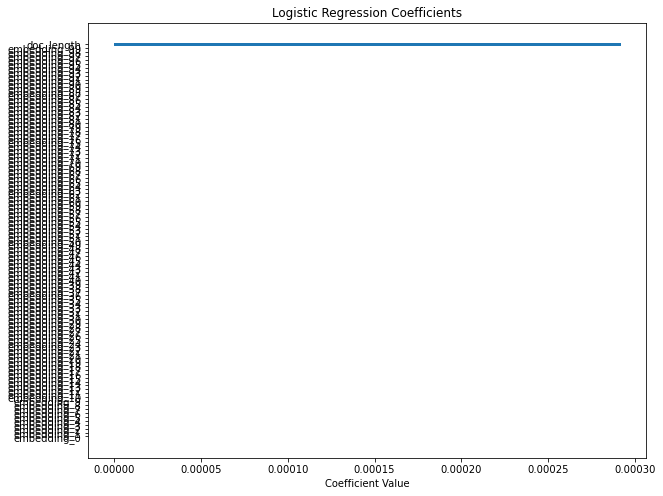

In [12]:
X_embeddings = np.vstack(mil_and_genz['doc_embedding'].to_numpy())
X_doc_length = mil_and_genz['doc_length'].to_numpy().reshape(-1, 1)
X = np.hstack([X_embeddings, X_doc_length])
y = mil_and_genz['binary_birth_year']

# train a simple logistic regression on this
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)

# evaluation
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print('\nClassification Report:\n', classification_rep)

# Get coefficients and feature names
coefficients = lr_model.coef_[0]
feature_names_embeddings = [f'embedding_{i}' for i in range(X_embeddings.shape[1])]
feature_names = feature_names_embeddings + ['doc_length']

# Plot coefficients
plt.figure(figsize=(10, 8))
plt.barh(range(len(coefficients)), coefficients, align='center')
plt.yticks(range(len(coefficients)), feature_names)
plt.xlabel('Coefficient Value')
plt.title('Logistic Regression Coefficients')
plt.show()

In [13]:
coefficients

array([ 4.59173387e-09,  7.82506059e-09,  3.90824997e-08,  8.64919930e-08,
       -1.58169854e-08, -2.25425569e-09, -2.53881676e-08, -1.03254424e-07,
       -1.24546250e-10,  2.98129565e-08,  1.75718969e-08,  1.76944716e-08,
       -3.58766411e-08,  5.11904022e-08,  4.92325582e-09,  3.62614031e-08,
       -4.22981891e-09, -4.97994339e-08, -4.98721052e-08,  5.10760435e-09,
       -3.57801667e-08, -2.35073954e-08,  6.11203808e-08, -1.56588530e-08,
       -8.89613986e-08,  4.48153754e-08, -2.32994493e-08,  3.10734660e-08,
        1.83533811e-08, -3.00804304e-08, -4.25552387e-08,  4.41047933e-08,
        3.41642452e-08,  8.48552682e-09,  4.45349103e-08,  1.29793497e-08,
        7.47928183e-08, -4.71318658e-08, -2.62853557e-08,  1.27536163e-08,
        2.17896848e-08, -1.49085684e-08, -2.05153651e-08, -4.97177558e-08,
       -1.14557074e-09,  5.87195588e-09, -6.39373453e-08, -6.82315796e-09,
       -6.31542250e-08, -8.28228767e-09, -5.60354384e-09, -1.86553803e-08,
        3.01249069e-08, -